In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import neurokit2 as nk
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Masking, GRU, Flatten, Conv1D, LSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, BatchNormalization, Dropout, ZeroPadding1D
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score,roc_auc_score

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# ECG Rhythm 추출 Code

In [2]:
def data_load(data, new_data, window, overlap):
    for i in range(0, len(data), overlap):
        if len(data[i:i+window]) < window:
            break
        else:
            new_data.append(data[i:i+window])
            
    return new_data

def shuffle_data(data, labels):
    # data와 label을 입력받아 무작위로 섞고 (인덱스 위치는 동일하게) Return
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    return data[indices], labels[indices], 

In [3]:
class_name = ['Amusement', 'Baseline','Stress']

In [4]:
person = ['S2','S3','S4','S5','S6','S7','S8','S9','S10','S11','S13','S14','S15','S16','S17']
Data = "D:/Database/WESAD/"
sampling_rate = 700
window = 5 * 700 # 5초 3,500 data point
overlap = 2 * 700 # 2초 중첩 1,400 data point

Train_normal, Valid_normal, Test_normal =[], [], [] # Normal Class Dataset
Train_stress, Valid_stress, Test_stress =[], [], [] # Stress Class Dataset
Train_amuse, Valid_amuse, Test_amuse =[], [], [] # Amuse Class Dataset

for i in range(len(person)):

    df = pd.read_pickle(Data + person[i] + '/' + person[i] + '.pkl')

    ecg_v = df['signal']['chest']['ECG'] # singl-chest-ecg 딕셔너리 값
    label = df['label']

    normal_ecg = np.array(ecg_v[np.where(label==1)[0]])
    stress_ecg = np.array(ecg_v[np.where(label==2)[0]])
    amuse_ecg = np.array(ecg_v[np.where(label==3)[0]])

    if i <= 8:
        
        Train_normal = data_load(normal_ecg, Train_normal, window, overlap)
        Train_stress = data_load(stress_ecg, Train_stress, window, overlap)
        Train_amuse = data_load(amuse_ecg, Train_amuse, window, overlap)
                
    elif i <= 11: 
        
        Valid_normal = data_load(normal_ecg, Valid_normal, window, overlap)
        Valid_stress = data_load(stress_ecg, Valid_stress, window, overlap)
        Valid_amuse = data_load(amuse_ecg, Valid_amuse, window, overlap)
        
    elif i <= 14:
        
        Test_normal = data_load(normal_ecg, Test_normal, window, overlap)
        Test_stress = data_load(stress_ecg, Test_stress, window, overlap)
        Test_amuse = data_load(amuse_ecg, Test_amuse, window, overlap)

In [5]:
len(Train_normal), len(Train_stress), len(Train_amuse)

(5250, 2917, 1653)

In [6]:
len(Train_stress), len(Valid_stress), len(Test_stress)

(2917, 1004, 1036)

In [7]:
len(Train_amuse), len(Valid_amuse), len(Test_amuse)

(1653, 555, 550)

In [8]:
Train_label = np.zeros((len(Train_amuse)), np.int32)
Train_label = np.concatenate((Train_label, np.ones(len(Train_normal) , np.int32)))
Train_label = np.concatenate((Train_label, np.ones(len(Train_stress), np.int32)+1))

Valid_label = np.zeros((len(Valid_amuse)), np.int32)
Valid_label = np.concatenate((Valid_label, np.ones(len(Valid_normal) , np.int32)))
Valid_label = np.concatenate((Valid_label, np.ones(len(Valid_stress), np.int32)+1))

Test_label = np.zeros((len(Test_amuse)), np.int32)
Test_label = np.concatenate((Test_label, np.ones(len(Test_normal) , np.int32)))
Test_label = np.concatenate((Test_label, np.ones(len(Test_stress), np.int32)+1))

In [9]:
np.bincount(Train_label) 
# 0 : Amuse, 1: Normal, 2: Stress

array([1653, 5250, 2917], dtype=int64)

In [10]:
np.bincount(Valid_label)

array([ 555, 1764, 1004], dtype=int64)

In [11]:
np.bincount(Test_label)

array([ 550, 1763, 1036], dtype=int64)

In [12]:
Train_data = np.concatenate([Train_amuse, Train_normal, Train_stress])
Valid_data = np.concatenate([Valid_amuse, Valid_normal, Valid_stress])
Test_data = np.concatenate([Test_amuse, Test_normal, Test_stress])

Train_data.shape, Valid_data.shape, Test_data.shape, Train_label.shape, Valid_label.shape, Test_label.shape

((9820, 3500, 1), (3323, 3500, 1), (3349, 3500, 1), (9820,), (3323,), (3349,))

In [13]:
train, train_y = shuffle_data(Train_data, Train_label)
valid, valid_y = shuffle_data(Valid_data, Valid_label)
test, test_y = shuffle_data(Test_data, Test_label)

In [14]:
from keras.utils import to_categorical
train_y = to_categorical(train_y,num_classes=3)
valid_y = to_categorical(valid_y,num_classes=3)

# Rhythm Modeling - 1DCNN

In [62]:

model = tf.keras.Sequential([
    Conv1D(64, 5, activation='relu', input_shape=(3500, 1)),
    Conv1D(64, 5,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),
    
    
    Conv1D(128, 5 ,activation='relu'),
    Conv1D(128, 5,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),
    
    
    Conv1D(256, 5,activation='relu'),
    Conv1D(256, 5,activation='relu'),
    BatchNormalization(),

    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(64)),
    
    
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, 3496, 64)          384       
                                                                 
 conv1d_69 (Conv1D)          (None, 3492, 64)          20544     
                                                                 
 max_pooling1d_33 (MaxPoolin  (None, 1746, 64)         0         
 g1D)                                                            
                                                                 
 batch_normalization_34 (Bat  (None, 1746, 64)         256       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 1746, 64)          0         
                                                                 
 conv1d_70 (Conv1D)          (None, 1742, 128)        

In [63]:
history = model.fit(train, train_y, validation_data=(valid, valid_y), epochs=200)

Epoch 1/200
307/307 [==============================] - 92s 197ms/step - loss: 0.9754 - accuracy: 0.5401 - val_loss: 1.0023 - val_accuracy: 0.5287
Epoch 2/200
307/307 [==============================] - 62s 201ms/step - loss: 0.9726 - accuracy: 0.5416 - val_loss: 0.9576 - val_accuracy: 0.5477
Epoch 3/200
307/307 [==============================] - 60s 196ms/step - loss: 0.9606 - accuracy: 0.5513 - val_loss: 1.1581 - val_accuracy: 0.3193
Epoch 4/200
307/307 [==============================] - 60s 195ms/step - loss: 0.9104 - accuracy: 0.5673 - val_loss: 0.9262 - val_accuracy: 0.6277
Epoch 5/200
307/307 [==============================] - 60s 196ms/step - loss: 0.9365 - accuracy: 0.5651 - val_loss: 1.0196 - val_accuracy: 0.5576
Epoch 6/200
307/307 [==============================] - 60s 195ms/step - loss: 0.9022 - accuracy: 0.5821 - val_loss: 0.9421 - val_accuracy: 0.5414
Epoch 7/200
307/307 [==============================] - 60s 196ms/step - loss: 0.7931 - accuracy: 0.6660 - val_loss: 1.1223 -

Epoch 57/200
307/307 [==============================] - 60s 196ms/step - loss: 0.0401 - accuracy: 0.9868 - val_loss: 2.9031 - val_accuracy: 0.4710
Epoch 58/200
307/307 [==============================] - 60s 194ms/step - loss: 0.0283 - accuracy: 0.9900 - val_loss: 3.0048 - val_accuracy: 0.5041
Epoch 59/200
307/307 [==============================] - 60s 194ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 3.1622 - val_accuracy: 0.4496
Epoch 60/200
307/307 [==============================] - 60s 195ms/step - loss: 0.0314 - accuracy: 0.9901 - val_loss: 3.7756 - val_accuracy: 0.3756
Epoch 61/200
307/307 [==============================] - 61s 197ms/step - loss: 0.0324 - accuracy: 0.9899 - val_loss: 2.9596 - val_accuracy: 0.4959
Epoch 62/200
307/307 [==============================] - 60s 197ms/step - loss: 0.0379 - accuracy: 0.9880 - val_loss: 2.5277 - val_accuracy: 0.4692
Epoch 63/200
307/307 [==============================] - 61s 197ms/step - loss: 0.0382 - accuracy: 0.9854 - val_loss: 2

307/307 [==============================] - 59s 192ms/step - loss: 0.0078 - accuracy: 0.9973 - val_loss: 5.7380 - val_accuracy: 0.4481
Epoch 168/200
307/307 [==============================] - 59s 194ms/step - loss: 0.0138 - accuracy: 0.9952 - val_loss: 3.9955 - val_accuracy: 0.5676
Epoch 169/200
307/307 [==============================] - 60s 195ms/step - loss: 0.0095 - accuracy: 0.9965 - val_loss: 4.8639 - val_accuracy: 0.5366
Epoch 170/200
307/307 [==============================] - 59s 193ms/step - loss: 0.0110 - accuracy: 0.9959 - val_loss: 3.5640 - val_accuracy: 0.4794
Epoch 171/200
307/307 [==============================] - 59s 193ms/step - loss: 0.0066 - accuracy: 0.9975 - val_loss: 5.4020 - val_accuracy: 0.4354
Epoch 172/200
307/307 [==============================] - 59s 192ms/step - loss: 0.0145 - accuracy: 0.9958 - val_loss: 4.1671 - val_accuracy: 0.4827
Epoch 173/200
307/307 [==============================] - 60s 195ms/step - loss: 0.0083 - accuracy: 0.9980 - val_loss: 3.5123 -

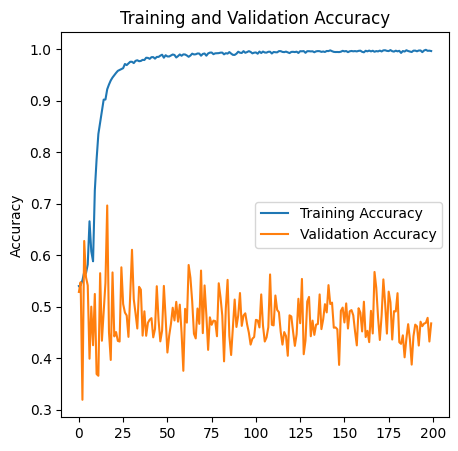

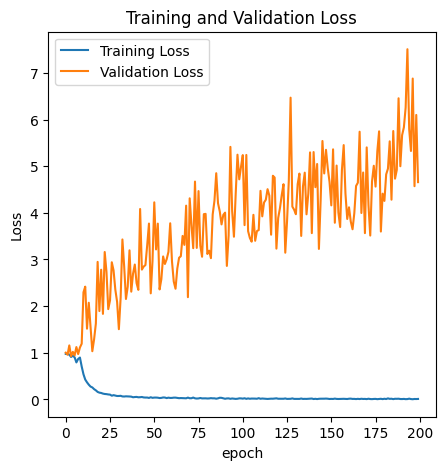

In [64]:
#Plotting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(5,5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [65]:
pred = model.predict(test)

# true_label = []
# for i in range(len(Test_label)):
#     true_label.append(np.argmax(Test_label[i]))
    
pred_label = []
for i in range(len(pred)):
    pred_label.append(np.argmax(pred[i]))

105/105 [==============================] - 9s 80ms/step


In [66]:
true_label = test_y

accuracy :  0.505
precision :  0.435
recall :  0.459
specificity :  0.459
F1_score :  0.388
              precision    recall  f1-score   support

       Amuse       0.02      0.01      0.02       550
      Normal       0.81      0.37      0.51      1763
      Stress       0.47      0.99      0.64      1036

    accuracy                           0.50      3349
   macro avg       0.43      0.46      0.39      3349
weighted avg       0.58      0.50      0.47      3349



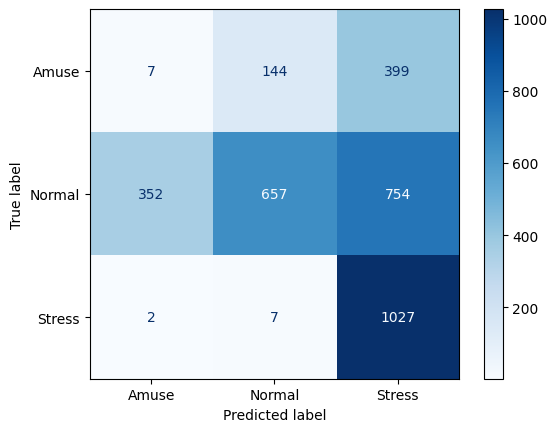

In [67]:
accuracy = accuracy_score(true_label, pred_label)
print('accuracy : ', np.round(accuracy,3))
precision = precision_score(true_label, pred_label, average='macro')
print('precision : ', np.round(precision,3))
recall = recall_score(true_label, pred_label,average='macro')
print('recall : ', np.round(recall,3))
specificity = recall_score(true_label, pred_label,average='macro')
print('specificity : ',np.round(specificity,3))
F1_score = f1_score(true_label, pred_label,average='macro')
print('F1_score : ', np.round(F1_score,3))

report = classification_report(true_label, pred_label, target_names=['Amuse', 'Normal','Stress'])
print(report)
confusion = confusion_matrix(true_label, pred_label)
disp = ConfusionMatrixDisplay(confusion, display_labels=['Amuse', 'Normal', 'Stress'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [68]:
save_model_path = 'D:/ICMLA/Model/'
model_name = 'Rhythm_원본_1DCNNBiLSTM_epochs(200)'
model.save(save_model_path + model_name + '.h5')

# K-Fold 만들기 

In [3]:
def load_Rhythm_level(data, window, overlap):
    rhythm_data = []
    for i in range(0, len(data), overlap):
        if len(data[i:i+window]) < window:
            break
        else:
            rhythm_data.append(data[i:i+window])
            
    return rhythm_data

def shuffle_data(data, labels):
    # data와 label을 입력받아 무작위로 섞고 (인덱스 위치는 동일하게) Return
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    return data[indices], labels[indices]

def load_data(subjects, name_class, window, overlap):
    
    # list of Train and Test 
    normal_train, stress_train, amuse_train =[], [], []
    normal_test, stress_test, amuse_test =[], [], []
    
    for i in subjects:
        # Person data load 
        df = pd.read_pickle(Data + i + '/' + i + '.pkl')

        ecg_v = df['signal']['chest']['ECG'] # singl-chest-ecg 딕셔너리 값
        label = df['label']
        
        # ECG data load 
        amuse_ecg = np.array(ecg_v[np.where(label==3)[0]])
        normal_ecg = np.array(ecg_v[np.where(label==1)[0]])
        stress_ecg = np.array(ecg_v[np.where(label==2)[0]])
        
        # load Rhythm Level data of each classes
        if name_class == 'train':
            amuse_train.append(load_Rhythm_level(amuse_ecg, window, overlap))
            normal_train.append(load_Rhythm_level(normal_ecg, window, overlap))
            stress_train.append(load_Rhythm_level(stress_ecg, window, overlap))
            
        else:
            amuse_test.append(load_Rhythm_level(amuse_ecg, window, overlap))
            normal_test.append(load_Rhythm_level(normal_ecg, window, overlap))
            stress_test.append(load_Rhythm_level(stress_ecg, window, overlap))
    
    # labeling, Concatenate Data
    if name_class == 'train':
        # Concatenate - Train data
        Train = np.concatenate([amuse_train, normal_train, stress_train])
        Train_label = np.concatenate([np.zeros(len(amuse_train), np.int32), np.ones(len(normal_train),np.int32)])
        Train_label = np.concatenate([Train_label, np.ones(len(stress_train),np.int32)+1])
        
        return Train, Train_label
    else :
        # COncatenate - Test data
        Test = np.concatenate([amuse_test, normal_test, stress_test])
        Test_label = np.concatenate([np.zeros(len(amuse_test), np.int32), np.ones(len(normal_test), np.int32), np.ones(len(stress_test),np.int32)+1])
        test, test_y = shuffle_data(Test, Test_label)
        
        return test, test_y

In [7]:
model = tf.keras.Sequential([
    Conv1D(16, 3, activation='relu', input_shape=(3500, 1)),
    Conv1D(16, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),
    
    
    Conv1D(32, 3 ,activation='relu'),
    Conv1D(32, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    Dropout(0.3),
    
    
    Conv1D(64, 3,activation='relu'),
    Conv1D(64, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(128, 3,activation='relu'),
    Conv1D(128, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(256, 3,activation='relu'),
    Conv1D(256, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),
    
    Conv1D(512, 3,activation='relu'),
    Conv1D(512, 3,activation='relu'),
    MaxPooling1D(2),
    BatchNormalization(),

    #LSTM(32, return_sequences=True),
    #LSTM(64),
    Flatten(),
    
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 3498, 16)          64        
                                                                 
 conv1d_33 (Conv1D)          (None, 3496, 16)          784       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 1748, 16)         0         
 g1D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 1748, 16)         64        
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 1748, 16)          0         
                                                                 
 conv1d_34 (Conv1D)          (None, 1746, 32)         

In [8]:
# library import
from sklearn.model_selection import KFold
from tensorflow.keras.models import clone_model
from keras.utils import to_categorical

# Initial settings
Data = "D:/Database/WESAD/"
sampling_rate = 700
window = 5 * 700 # 5초 3,500 data point
overlap = 2 * 700 # 2초 중첩 1,400 data point 
n_split = 5 # num of Fold
random_state = 42
subjects = np.array(['S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16', 'S17'])
accuracies = [] # Fold accuracy list
fold_i = 0

# K-fold Code start
kf = KFold(n_splits=n_split, shuffle=True, random_state=random_state)

for train_index, test_index in kf.split(subjects):
    
    
    train_subjects, test_subjects = subjects[train_index], subjects[test_index]
    
    # Train Data load
    train_data, train_labels = load_data(train_subjects, 'train', window, overlap)
    
    # 훈련 개수만큼 라벨 재조정
    train_label = [] 
    for i in range(len(train_data)):
        if train_labels[i] == 0:
            train_label.append(np.zeros(len(train_data[i]), np.int32))

        elif train_labels[i] == 1:
            train_label.append(np.ones(len(train_data[i]), np.int32))

        else:
            train_label.append(np.ones(len(train_data[i]), np.int32)+1)
    
    # Shuffle
    train, train_y = shuffle_data(np.concatenate(train_data), np.concatenate(train_label))
    
    # Test Data load
    test_data, test_labels = load_data(test_subjects, 'test', window, overlap)
    
    # # 훈련 개수만큼 라벨 재조정
    test_lable =[]
    for i in range(len(test_data)):
        if test_labels[i] == 0:
            test_lable.append(np.zeros(len(test_data[i]), np.int32))

        elif test_labels[i] == 1:
            test_lable.append(np.ones(len(test_data[i]), np.int32))

        else:
            test_lable.append(np.ones(len(test_data[i]), np.int32)+1)
    
    # Shuffle 
    test, test_y = shuffle_data(np.concatenate(test_data), np.concatenate(test_lable))
    
    # One-hot Encoding
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    
    print('Train:', train_index, 'Test', test_index)
    
    #model = MyCustomModel()
    # Model Training 
    model_clone = clone_model(model)
    model_clone.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_clone.fit(train, train_y, epochs=50, batch_size=32) 
    scores = model_clone.evaluate(test, test_y)
    accuracies.append(scores[1])
    
    fold_i += 1
    print(fold_i, '번째 검증')
    

average_accuracy = np.mean(accuracies)
print('평균 정확도 : ', average_accuracy)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Train: [ 1  2  3  4  5  6  7  8 10 12 13 14] Test [ 0  9 11]
Epoch 1/50
414/414 [==============================] - 14s 19ms/step - loss: 0.7094 - accuracy: 0.7294
Epoch 2/50
414/414 [==============================] - 8s 19ms/step - loss: 0.3647 - accuracy: 0.8525
Epoch 3/50
414/414 [==============================] - 8s 19ms/step - loss: 0.2592 - accuracy: 0.8980
Epoch 4/50
414/414 [==============================] - 8s 19ms/step - loss: 0.2105 - accuracy: 0.9175
Epoch 5/50
414/414 [==============================] - 8s 19ms/step - loss: 0.1967 - accuracy: 0.9267
Epoch 6/50
414/414 [==============================] - 8s 19ms/step - loss: 0.1490 - accuracy: 0.9440
Epoch 7/50
414/414 [==============================] - 8s 19ms/step - loss: 0.1356 - accuracy: 0.9482
Epoch 8/50
414/414 [==============================] - 8s 19ms/step - loss: 0.1058 - accuracy: 0.9625
Epoch 9/50
414/414 [==============================] - 8s 19ms/step - loss: 0.1007 - accuracy: 0.9660
Epoch 10/50
414/414 [========

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Train: [ 0  1  2  3  4  6  7  9 10 11 12 14] Test [ 5  8 13]
Epoch 1/50
412/412 [==============================] - 9s 19ms/step - loss: 0.7316 - accuracy: 0.7218
Epoch 2/50
412/412 [==============================] - 8s 19ms/step - loss: 0.4121 - accuracy: 0.8336
Epoch 3/50
412/412 [==============================] - 8s 19ms/step - loss: 0.3333 - accuracy: 0.8683
Epoch 4/50
412/412 [==============================] - 8s 19ms/step - loss: 0.2647 - accuracy: 0.8924
Epoch 5/50
412/412 [==============================] - 8s 19ms/step - loss: 0.2124 - accuracy: 0.9166
Epoch 6/50
412/412 [==============================] - 8s 19ms/step - loss: 0.1776 - accuracy: 0.9296
Epoch 7/50
412/412 [==============================] - 8s 19ms/step - loss: 0.1463 - accuracy: 0.9423
Epoch 8/50
412/412 [==============================] - 8s 19ms/step - loss: 0.1355 - accuracy: 0.9492
Epoch 9/50
412/412 [==============================] - 8s 19ms/step - loss: 0.1037 - accuracy: 0.9637
Epoch 10/50
412/412 [=========

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Train: [ 0  3  4  5  6  7  8  9 10 11 12 13] Test [ 1  2 14]
Epoch 1/50
413/413 [==============================] - 9s 19ms/step - loss: 0.6761 - accuracy: 0.7443
Epoch 2/50
413/413 [==============================] - 8s 19ms/step - loss: 0.3612 - accuracy: 0.8594
Epoch 3/50
413/413 [==============================] - 8s 19ms/step - loss: 0.2627 - accuracy: 0.8970
Epoch 4/50
413/413 [==============================] - 8s 19ms/step - loss: 0.2187 - accuracy: 0.9138
Epoch 5/50
413/413 [==============================] - 8s 19ms/step - loss: 0.1849 - accuracy: 0.9270
Epoch 6/50
413/413 [==============================] - 8s 19ms/step - loss: 0.1483 - accuracy: 0.9424
Epoch 7/50
413/413 [==============================] - 8s 19ms/step - loss: 0.1312 - accuracy: 0.9501
Epoch 8/50
413/413 [==============================] - 8s 19ms/step - loss: 0.1161 - accuracy: 0.9572
Epoch 9/50
413/413 [==============================] - 8s 19ms/step - loss: 0.1007 - accuracy: 0.9650
Epoch 10/50
413/413 [=========

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 4 dimension(s)

# Subclassing Model 생성 방법

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, LSTM, Bidirectional

class MyCustomModel(Model):
    def __init__(self):
        super(MyCustomModel, self).__init__()
        # Define all layers in the __init__ method
        self.conv1 = Conv1D(64, 5, activation='relu')
        self.conv2 = Conv1D(64, 5, activation='relu')
        self.pool1 = MaxPooling1D(2)
        self.norm1 = BatchNormalization()
        self.drop1 = Dropout(0.3)
        
        self.conv3 = Conv1D(128, 5, activation='relu')
        self.conv4 = Conv1D(128, 5, activation='relu')
        self.pool2 = MaxPooling1D(2)
        self.norm2 = BatchNormalization()
        self.drop2 = Dropout(0.3)
        
        self.conv5 = Conv1D(256, 5, activation='relu')
        self.conv6 = Conv1D(256, 5, activation='relu')
        self.norm3 = BatchNormalization()
        
        self.bi_lstm1 = Bidirectional(LSTM(32, return_sequences=True))
        self.bi_lstm2 = Bidirectional(LSTM(64))
        
        self.dense1 = Dense(512, activation='relu')
        self.dense2 = Dense(1024, activation='relu')
        self.dense3 = Dense(3, activation='softmax')

    def call(self, inputs):
        # Define the forward pass
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.drop1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.norm2(x)
        x = self.drop2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.norm3(x)
        
        x = self.bi_lstm1(x)
        x = self.bi_lstm2(x)
        
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        return x